
# Eclipse Morphology Part 4: *The Variational Autoencoder*

***Author: Marc Hon***

In Part 3, we explored the use of Self-Organizing Maps (SOMs) as a way of visualizing a low-dimensional representation of the dataset comprising the shapes of eclipsing binary light curves. SOMs have the nice property of preserving topological information, such that light curves that are morphologically similar are typically placed nearby in the SOM.

Here, we explore a powerful approach to provide a low-dimensional representation with similar properties, but instead using a **variational autoencoder (VAE)**. A variational autoencoder's overall objective is similar to that of an autoencoder in that it compresses the input data into a low-dimensional latent space and attempts to reconstruct the data using features from the latent space.

Compared to a conventional autoencoder, the latent space of a VAE is probabilistic, following an easy-to-sample distribution (typically Gaussian). Because the latent space is designed to follow this distribution, the latent space is constrained to be **smooth and continuous**.

In [1]:
import os, torch
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchinfo import summary
from pathlib import Path

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fs = 18

We will use the same scaled dataset as before, defined as the variable `scaled_flux`.

In [2]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

dataset = np.load(os.path.join(data_folder_path, 'KeplerEB_Filtered.npz'))
scaled_flux = TimeSeriesScalerMinMax(value_range=(0, 1)).fit_transform(dataset['flux'][:, 1, :]).squeeze()

Since we will be using PyTorch, we first wrap the input data into a Tensor instance and pass it to a DataLoader.

In [3]:
batch_size = 16

input_data = torch.Tensor(scaled_flux).to(device)
input_dataset = TensorDataset(input_data)
trainloader = DataLoader(dataset=input_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=input_dataset, batch_size=batch_size, shuffle=False)

The DataLoader is an iterable, so we may step through it manually to visualize several examples.

Text(0, 0.5, 'Phase-folded Flux')

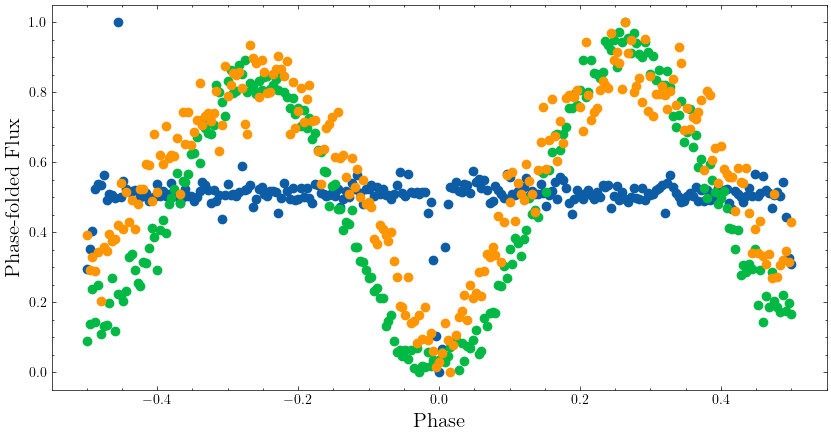

In [4]:
dataiter = iter(trainloader); examples = next(dataiter)[0]
fig = plt.figure(figsize=(10, 5)); ax1 = fig.add_subplot(111)
[plt.scatter(dataset['flux'][0][0], flx) for flx in examples[:3].data.cpu().numpy()]
plt.xlabel('Phase', fontsize=fs-3); plt.ylabel('Phase-folded Flux', fontsize=fs-3)    

## VAE Architecture

We will use a simple encoder-decoder architecture using multi-layer perceptrons. The crucial structure in this architecture is defining a latent space that is inherently stochastic, i.e., can be sampled from. To do this:

- The encoder predicts the parameters of a Gaussian distribution, namely the mean $\mu$ and the log variance $\log \sigma^2$ for each input sample, $x$.
- Sampling from the latent distribution is then performed by drawing values from $z\sim \mathcal{N}(\mu,\sigma^2)$.
- The decoder takes $z$ as input and produces a reconstruction of the input data, $x^\prime$.


![vae-gaussian](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/vae-gaussian.png)

*Figure.* Schematic of a Variational Autoencoder (VAE) from [BayesLab](https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html).


In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=input_data.size()[1], hidden_dim=128, latent_dim=32, device=device):
        super(VAE, self).__init__()

        # Encoder Network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # Two Separate Networks for the Mean and LogVariance of Latent Layer set to 2D for later visualization
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # Decoder Network
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        var = torch.exp(logvar)
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x) # First, encode data into parameters describing latent space 
        z = self.reparameterization(mean, logvar) # uses the reparameterization trick to allow this latent space
                                                  # to be differentiable
        x_prime = self.decode(z) # Decode the latent space to produce a reconstruction
        return x_prime, mean, logvar

Here, we define the model, which has the following structure:

![vae](https://raw.githubusercontent.com/mtyhon/ais5201/master/chapter1/images/vae.png)

In [6]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
summary(model, input_size=(1, input_data.size()[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 251]                  --
├─Sequential: 1-1                        [1, 32]                   --
│    └─Linear: 2-1                       [1, 128]                  32,256
│    └─LeakyReLU: 2-2                    [1, 128]                  --
│    └─Linear: 2-3                       [1, 32]                   4,128
│    └─LeakyReLU: 2-4                    [1, 32]                   --
├─Linear: 1-2                            [1, 2]                    66
├─Linear: 1-3                            [1, 2]                    66
├─Sequential: 1-4                        [1, 251]                  --
│    └─Linear: 2-5                       [1, 32]                   96
│    └─LeakyReLU: 2-6                    [1, 32]                   --
│    └─Linear: 2-7                       [1, 128]                  4,224
│    └─LeakyReLU: 2-8                    [1, 128]                  --
│    

## VAE Loss

The loss function for the VAE aims to find the encoder parameters $\phi$ and decoder parameters $\theta$ that maximize the Evidence Lower Bound (ELBO), given by:

$$
\begin{aligned}
\\ \mathrm{ELBO}(\phi, \theta) = \sum_{i=1}^n \mathbb{E}_{z_i\sim q} \left[ \log p_\theta(\mathbf{x_i}|\mathbf{z_i}) \right] - \mathrm{KL}(q(\mathbf{z_i}|\mathbf{x_i})\,||\,p(\mathbf{z_i})).
\end{aligned}
$$

When the the prior distribution $p(\mathbf{z})$ is assumed to be normally distributed, then the Kullback-Leibler (KL) divergence takes the following form:

$$
\begin{aligned}
\\ \mathrm{KL}(q(\mathbf{z}|\mathbf{x})\,||\,p(\mathbf{z})) = -\frac{1}{2} \sum_{j=1}^J \left( 1 + \log\mathbf{\sigma}^2_j - \mathbf{\mu}^2_j - \exp( \log\mathbf{\sigma}^2) \right),
\end{aligned}
$$

where $J$ is the dimensionality of $\mathbf{z}$. 

<details>
  <summary><strong>Derivation of simplified form of KL divergence</strong> (click to expand)</summary>

> By definition,
>
>$$
\begin{align}
\mathrm{KL}(q||p) &= \mathbb{E}_{q}\left[\log\frac{q}{p}\right] = \mathbb{E}_{q}\left[\log(q) - \log(p) \right], \qquad q = \mathcal{N}(\mu, \sigma^2 \mathcal{I}), \qquad p = \mathcal{N}(0, \mathcal{I}) \\
\end{align}
$$
>
> For the variational distribution $q$, we have:
>
> $$
\begin{align}
\log(q) &= -\frac{(z - \mu)^2}{2\sigma^2} - \frac{1}{2} \log(2\pi\sigma^2)\quad \rightarrow \mathbb{E}_{q}[\log(q)] = -\frac{1}{2}\left[ 1 + \log(2\pi\sigma^2)\right],
\end{align}
$$  
>
> where we make use of $\mathbb{E}_{q}(z - \mu)^2 = \sigma^2$. For the prior distribution $p$, we have:
>
> $$
\begin{align}
\log(p) &= -\frac{z^2}{2} - \frac{1}{2} \log(2\pi)\quad \rightarrow \mathbb{E}_{q}[\log(p)] = -\frac{1}{2}\left[ \sigma^2 + \mu^2 + \log(2\pi)\right],
\end{align}
$$
>
> making use of the fact that $\mathbb{E}[z^2] = \text{Var}(z) + (\mathbb{E}[z])^2 = \sigma^2 + (\mathbb{E}[z])^2$. Putting it all together:
>
> $$
\begin{align}
\mathbb{E}_{q}\left[\log(q) - \log(p) \right] &= \mathbb{E}_{q}\left[\log(q)\right] -\mathbb{E}_{q}\left[\log(p)\right]\\
&= -\frac{1}{2}\left[1 + \log\sigma^2 - \mu^2 - \sigma^2 \right]
\end{align}
$$
>
> as desired.
</details>

---------------------------------------------------------

The ELBO is thus a combination of:

1. **Maximizing** the log-likelihood of the data given the latent variable $z$, which is equivalent to **minimizing** the reconstruction error between $x$ and $x^\prime$.

2. **Minimizing** the KL divergence, which measures the dissimilarity of the variables between the approximate posterior distribution and the prior distribution. 

This objective is coded as the following:

In [7]:
def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss, KLD

We now train the model in the following code block:

In [8]:
num_epochs = 1500
input_dim = input_data.size()[1]

model.train()

for epoch in range(num_epochs): # for each epoch
    epoch_repr_loss = 0
    epoch_kl_loss = 0
    
    for batch_idx, x in enumerate(trainloader): # grab a batch from the dataloader
        
        x = x[0].to(device) 
        optimizer.zero_grad() # prepare the optimizer to accept fresh updates
        x_prime, mean, log_var = model(x) # forward pass through networks
        reproduction_loss, kld = loss_function(x, x_prime, mean, log_var) # calculate the loss
        loss = reproduction_loss +  0.002 * kld
        
        epoch_repr_loss += reproduction_loss.item() # keep track of individual loss across the batches
        epoch_kl_loss += kld.item()
            
        loss.backward()   # propagate gradients backward
        optimizer.step() # update parameters
        
    if not epoch % 250:
        print(f"\tEpoch {epoch + 1}", f"\tAverage Reconstruction Loss: {epoch_repr_loss/(batch_idx*batch_size):.3f}", 
             f"\tAverage KLD: {epoch_kl_loss/(batch_idx*batch_size):.3f}")

	Epoch 1 	Average Reconstruction Loss: 15.779 	Average KLD: 16.597
	Epoch 251 	Average Reconstruction Loss: 1.437 	Average KLD: 5.940
	Epoch 501 	Average Reconstruction Loss: 1.374 	Average KLD: 5.600
	Epoch 751 	Average Reconstruction Loss: 1.335 	Average KLD: 5.513
	Epoch 1001 	Average Reconstruction Loss: 1.341 	Average KLD: 5.501
	Epoch 1251 	Average Reconstruction Loss: 1.290 	Average KLD: 5.448


> **Balancing Loss Contributions**  
Notice that the contribution of the KL Divergence (KLD) is multiplied by a factor of 0.002.
>
> Recall that the KLD encourages the latent distribution $q_{\phi}(\mathbf{z} | \mathbf{x})$ to align with the prior $p(\mathbf{z})$, which here is the normal distribution. Down-weighting the KLD contribution during training thus allows the latent distribution more freedom to deviate from the prior, and sampling from this more flexible prior distribution produces a larger variance in the decoded samples. This increased freedom also allows more focus on accurately reconstructing the data, however, it comes at the cost of having a latent space that is less structured, i.e., less aligned with the prior.


## Visualizing the Latent Space
Let's now visualize the learned latent space by sampling across a range of $\mathbf{z}$. Note that we are sampling $\mathbf{z}$, not $\mathbf{\mu}$ and $\mathbf{\sigma}$, and so the reconstructions shown are deterministic.

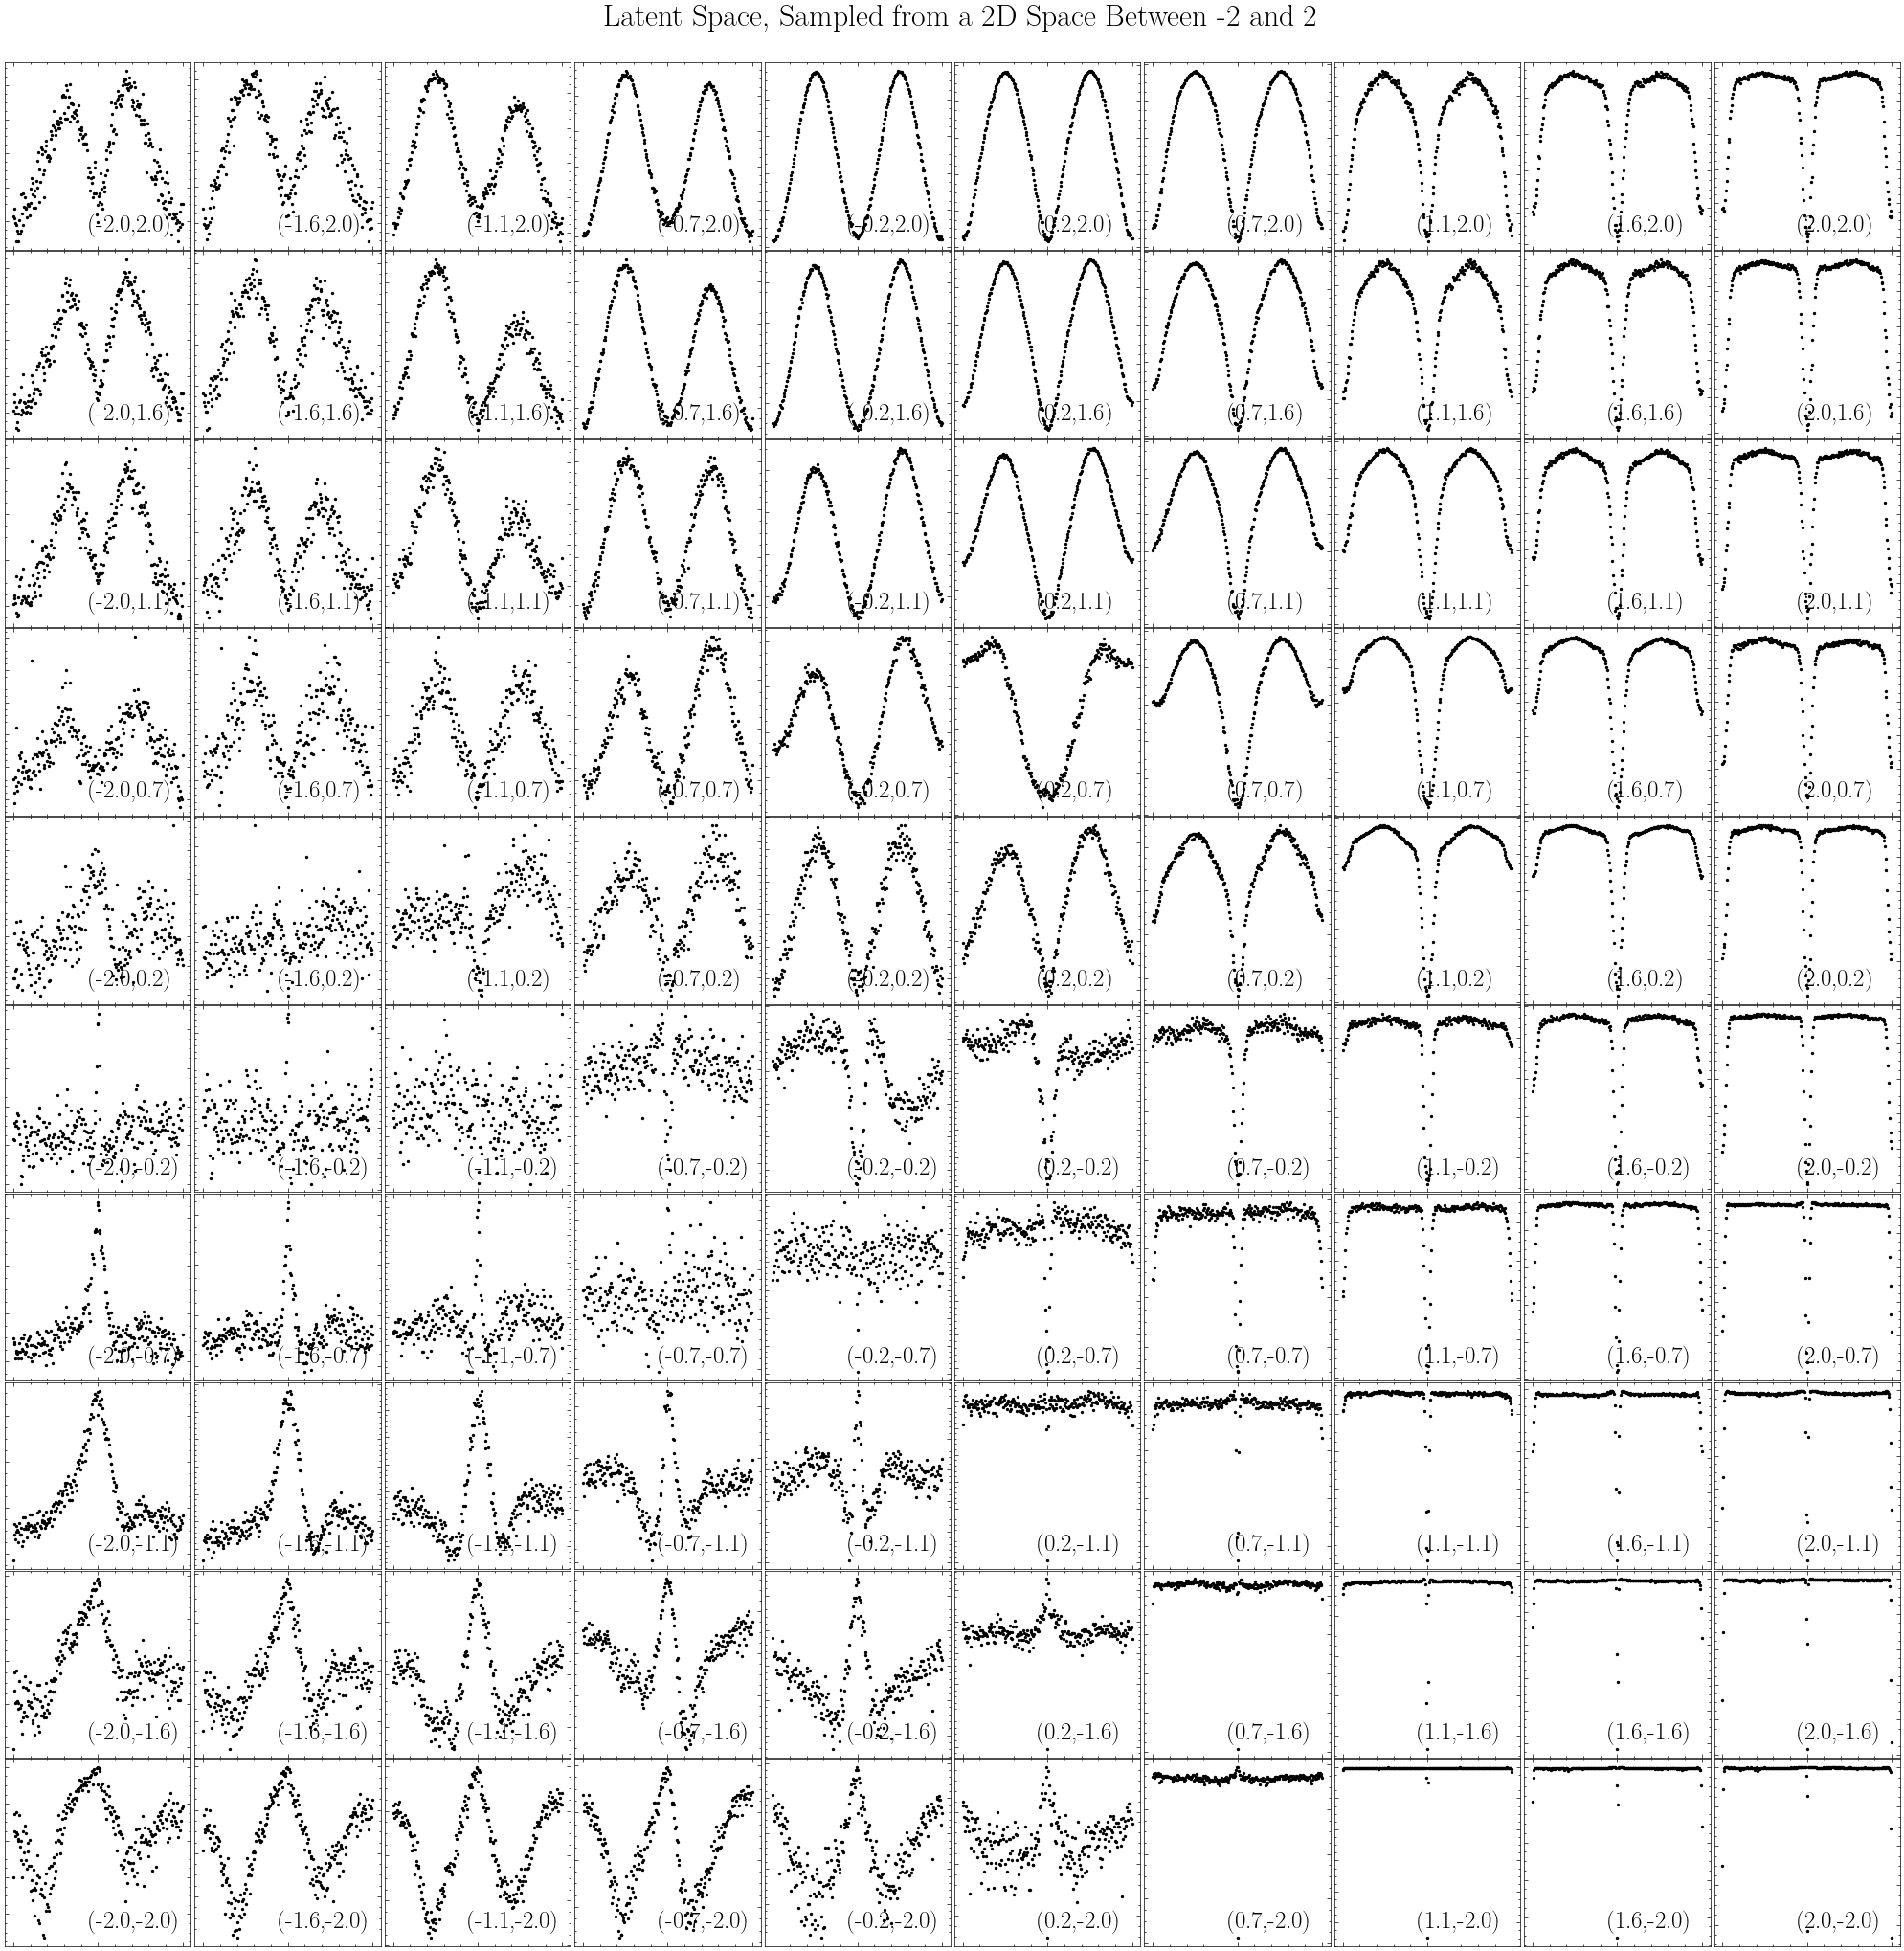

In [9]:
n = 10; scale = 2
grid_x = np.linspace(-scale, scale, n); grid_y = np.linspace(-scale, scale, n)[::-1]
fig = plt.figure(figsize=(20, 20))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        ax = fig.add_subplot(n, n, n*i + j + 1)
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
        x_decoded = model.decode(z_sample).data.cpu().numpy()
        ax.scatter(dataset['flux'][0][0], x_decoded.squeeze(), c='k', s=2)
        ax.set_xticklabels([]); ax.set_yticklabels([])
        ax.text(s=f'({xi:.1f},{yi:.1f})', transform=ax.transAxes, x=0.45, y=0.1, fontsize=fs)
plt.suptitle(f'Latent Space, Sampled from a 2D Space Between {-scale} and {scale}', fontsize=fs+5, y=1.015)
plt.tight_layout(pad=0.1, w_pad=-1.5)

## Generating Samples

To generate random examples, we allow for stochasticity when invoking the decoder. This means that instead of passing a specific value $\mathbf{z}$ to the decoder, we obtain $\mathbf{z}$ by sampling from the prior distribution, $p(\mathbf{z})\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$.

Text(0, 0.5, 'Phase-folded Flux')

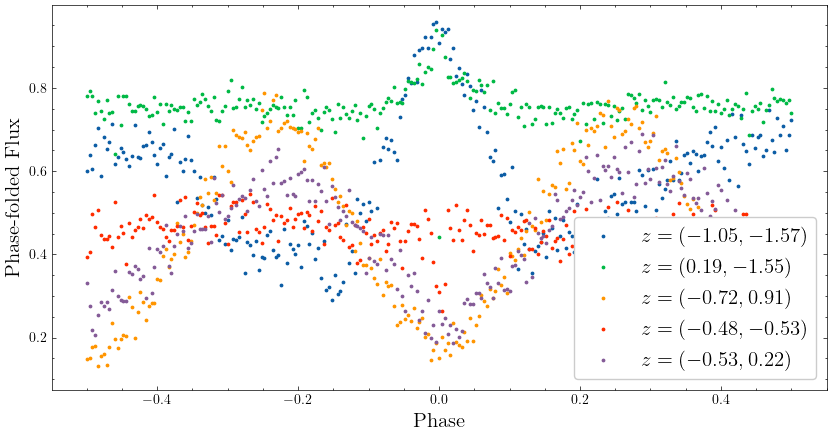

In [10]:
num_samps = 5
z_sample = torch.randn((num_samps,2)).to(device)
x_prime = model.decode(z_sample).data.cpu().numpy()

fig = plt.figure(figsize=(10, 5));

for idx in range(num_samps):
    plt.scatter(dataset['flux'][0][0], x_prime[idx].squeeze(), s=3, label=f'$z=({z_sample[idx,0]:.2f},{z_sample[idx,1]:.2f})$')
    
plt.legend(frameon=True, prop={'size': fs-3},
          framealpha=1); plt.xlabel('Phase', fontsize=fs-3); plt.ylabel('Phase-folded Flux', fontsize=fs-3)    

## Distribution of The Input Dataset in Latent Space


Another way of visualizing the inner workings of the VAE is to observe the distribution of encoded samples in latent space $(\mathbf{x} \rightarrow \mathbf{z})$, which aims to follow the distribution set by the prior distribution $p(\mathbf{z})$. The process is straightforward; we simply take the first half of the VAE's forward pass.

In [11]:
z_vectors = []
for _, x in enumerate(testloader): 
    x = x[0].to(device) 
    mean, logvar = model.encode(x)
    z = model.reparameterization(mean, logvar)
    z_vectors.append(z.data.cpu().numpy())
z_vectors = np.concatenate(z_vectors)

In [14]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource, HoverTool,LinearColorMapper, ColorBar, FixedTicker, BasicTicker, PrintfTickFormatter
output_notebook()

kics = dataset['kic']
ebcat = pd.read_csv(os.path.join(data_folder_path, 'eb_morph.dat')).drop_duplicates(subset='kic')

def bokeh_projection_vae(z_vectors, xlabel, ylabel, title, color=None):
        
    pca_df = pd.DataFrame({'pca_1': z_vectors[:,0],
                          'pca_2': z_vectors[:,1],
                            'kic': kics,
                           'color': color,
                          'image_url': [f'https://raw.githubusercontent.com/mtyhon/image_data/refs/heads/master/kepler_eb/{str(idx).zfill(8)}.png' for idx in kics]})


    p = figure(width=800, height=800, title=title)
    
    if color is not None:
        color_mapper = LinearColorMapper(palette="Viridis256", low=min(pca_df.color), high=max(pca_df.color))
        p.circle('pca_1', 'pca_2', size=5.5, source=ColumnDataSource(pca_df), 
                 color=linear_cmap('color', 'Viridis256', 
                                   min(pca_df.color), max(pca_df.color)),line_color='black',
                 line_width=0.2,)
        color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), 
                             label_standoff=12, location=(0,0),
                             title='Literature Morphological Parameter (c)',
                     major_label_text_font_size=f"{fs-3}pt")
        p.add_layout(color_bar, 'right')
    else:
        p.circle('pca_1', 'pca_2', size=5.5, source=ColumnDataSource(pca_df), color='royalblue',line_color='black', line_width=0.2,)
    
    hover = HoverTool(tooltips = f"""
        <div>
            <div style="font-size: {fs}px;"><strong>KIC @kic </strong></div>
            <div><img src="@image_url" alt="" width="400" /></div>
        </div>
    """)
    p.add_tools(hover)
    p.xaxis.axis_label = xlabel; p.yaxis.axis_label = ylabel
    p.xaxis.axis_label_text_font_size = f'{fs}pt' ;p.yaxis.axis_label_text_font_size = f'{fs}pt' 
    p.xaxis.major_label_text_font_size = f'{fs-2}pt' ;p.yaxis.major_label_text_font_size = f'{fs-2}pt' 
    p.title.text_font_size = f'{fs-3}pt' ;p.title.text_color = 'black'  ; p.title.text_font_style = 'bold' 
    show(p)
    
bokeh_projection_vae(z_vectors, 
                xlabel = f"Latent Variable (z) Dim 1",
                ylabel = f"Latent Variable (z) Dim 2",
                title = "VAE Latent Space",
                    color = [ebcat.morph.values[np.where(ebcat.kic.values == k)[0][0]] for k in kics])

Loading BokehJS ...

The above shows that structure in the 2D latent space is indeed correlated with the morphological parameter `c` described in Part 2 with the Locally Linear Embedding. However, note two observations:

- The distribution of $\mathbf{z}$ does not conform to a multivariate normal distribution.
- Regions of low or density in the latent space reflect the frequency of particular types of examples across the dataset. Rarer or more peculiar examples, for instance, are mapped to unique locations in the 2D space.

> **Assignment**
> 
> Experiment with changing the following in the VAE architecture:
>
> - The size of the **latent layer**.
> - The relative weight of the KL Divergence in the loss function.
>
> Plot the 2D latent space for each variation (use PCA/t-SNE/UMAP if needed), colored by the morphological parameter `c`. What kind of variation creates more structured latent spaces?Zz